In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim

import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import os
from utils.svg import SVG
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
from torchsummary import summary

import utils.dataloader as dl
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import shutil
import optuna
from optuna.trial import TrialState

from IPython import display
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 80
# fonts_number = 100
fonts_number = None

print(f'Device: {device}')

Device: cuda


In [3]:
print('Loading data')
dl.load_data(fonts_number)

Loading data
<###############_________________________________________________________________>: 19.8% [3000 / 15147]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



<####################################____________________________________________>: 45.2% [6852 / 15147]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



<###########################################################_____________________>: 74.4% [11270 / 15147]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



<################################################################################>: 100.% [15147 / 15147]


In [4]:
print('Encoding data')
stored_path = Path(f'data/data_{SVG.ENCODE_HEIGHT}_{fonts_number}.json')
if stored_path.exists():
    data = pd.read_json(str(stored_path))
    # data['data'] = data['data'].apply(lambda x: np.array(x))
else:
    data = dl.get_data(fonts_number)
    data.to_json(str(stored_path))
data

Encoding data


,font,letter,data
0,!crass_roots_ofl,a,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,!crass_roots_ofl,b,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,!crass_roots_ofl,c,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,!crass_roots_ofl,d,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,!crass_roots_ofl,e,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
337538,çarsi,v,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337539,çarsi,w,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337540,çarsi,x,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337541,çarsi,y,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [5]:
class Dataloader:
    def __init__(self, df: pd.DataFrame, test_size=0.1, shuffle=False, batch_size=24):
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        xs = np.array(df['data'].to_list(), dtype=np.float32)
        ys = df['letter'].to_numpy()
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(xs, ys, test_size=test_size, shuffle=shuffle)
        self.batch_size = batch_size

    def iterate(self):
        bs = self.batch_size
        for i in range(len(self.x_train) // bs):
            yield self.x_train[i * bs: (i + 1) * bs], self.y_train[i * bs: (i + 1) * bs]

    def iterate_test(self):
        yield self.x_test, self.y_test

    def __len__(self):
        return len(self.x_train) // self.batch_size + int(len(self.x_train) % self.batch_size > 0)

In [6]:
dataloader = Dataloader(data, test_size=0.15, shuffle=True)

In [7]:
def save_sampled(x: np.ndarray, name, close=True):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

In [8]:
save_sampled(dataloader.x_test[3], 'test_print.svg', close=False)

In [26]:
statistic_var = []

class BnAndDropout(nn.Module):
    def __init__(self, features, p=0.15):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features=features)
        self.do = nn.Dropout(p)
    
    def forward(self, x):
        return self.do(self.bn(x))


class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x):
        return self.layer(x)


class Coder(nn.Module):
    def __init__(self, shape, out):
        super().__init__()
        self.matrix = nn.Layer(shape[1], out)

    def forward(self, x):
        return self.matrix(x)
    

class VEncoder(nn.Module):
    def __init__(self, in_features, in_labels, shape, params=None, vae=False):
        super().__init__()
        self.in_features = in_features
        self.in_labels = in_labels
        self.all_in = in_features + in_labels
        self.vae = vae

        layers = []
        
        params.insert(0, self.all_in)
        for i in range(len(params) - 2):
            layers.append(Block(params[i], params[i + 1]))

        self.layers = nn.Sequential(*layers)

        self.layer_mu = nn.Linear(params[-2], params[-1])
        self.layer_logvar = nn.Linear(params[-2], params[-1])
        self.mu_activate = nn.Tanh()
        self.v_activate = nn.Softplus()

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)

        self.kl = 0

    def forward(self, x, labels):
        x = x.view(-1, self.in_features)
        x = torch.cat((x, labels), 1)
        
        x = self.layers(x)
        mu = self.mu_activate(self.layer_mu(x))

        if self.vae:
            log_var = self.layer_logvar(x)
            var = log_var.exp()
            z = mu + torch.sqrt(var) * self.N.sample(mu.shape)
            self.kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim=1), dim=0)
            
            statistic_var.append(np.absolute(var.cpu().detach().numpy()).mean())
            return z
        else:
            return mu
        return mu


class VDecoder(nn.Module):
    def __init__(self, out_features, in_labels, out_shape, params=None):
        super().__init__()
        self.out_features = out_features
        self.in_labels = in_labels
        self.out_shape = out_shape

        layers = []
        params[0] += in_labels
        params.append(out_features)
        for i in range(len(params) - 1):
            layers.append(Block(params[i], params[i + 1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x, labels):
        x = torch.cat((x, labels), 1)
        d = self.layers(x)
        out = d.view(-1, *self.out_shape)
        
        return out

    
class Vae(nn.Module):
    def __init__(self, shape, label_size, params, vae=False):
        super().__init__()

        self._vae = vae

        self.shape = shape
        self.in_features = shape[0] * shape[1]
        self.encoder = VEncoder(self.in_features, label_size, self.shape, params, vae=vae)
        self.decoder = VDecoder(self.in_features, label_size, self.shape, params[::-1])
        
    def forward(self, x, labels):
        z = self.encoder(x, labels)
        return self.decoder(z, labels)

    def loss(self):
        def _inner(y_hat, y):
            sum_loss = ((y - y_hat)**2).mean(axis=0).sum()
            if self.vae:
                sum_loss += self.encoder.kl
            return sum_loss
            
        return _inner
    
    @property
    def vae(self):
        return self._vae

    @vae.setter
    def vae(self, vae):
        self._vae = vae
        self.encoder.vae = vae
  


In [27]:
ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}

def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()

def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)

In [28]:
interval = 200

train_ts, train_loss = [], []
test_ts, test_loss = [], []


def show_progress(t, epochs, save_to=None, params=None, lr=None):
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
    fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)
    
    last_size = 0.5
    
    for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
        title = f'loss {msg}' + (f' | params = {params}' if params else '') + (f' | lr = {lr}' if lr else '')
        ax.set_title(title)
        ax.set_xlabel('time (epochs)')
        ax.set_ylabel('loss')
    last_train = str(train_loss[-1]) if len(train_loss) > 0 else ''
    last_test = str(test_loss[-1]) if len(test_loss) > 0 else ''
    
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
    ax1.plot(test_ts, test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')
    
    ax2.plot(train_ts[-int(len(train_ts)*last_size):], train_loss[-int(len(train_loss)*last_size):], c='darkblue', lw=3, label=f'train: {last_train}')
    ax2.plot(test_ts[-int(len(test_ts)*last_size):], test_loss[-int(len(test_loss)*last_size):], c='green', marker='o', lw=5, label=f'test: {last_test}')
    
    ax1.legend()
    ax2.legend()
    if save_to is None:
        plt.show() 
    else:
        plt.savefig(save_to)
        plt.close()
    
def train(epoch, epochs, dataloader, model, loss_fn, optimizer, scheduler, pbar=None, show=True):
    model.train()
    num_batches = len(dataloader)
    for batch, (images, labels) in enumerate(dataloader.iterate()):
        images = torch.Tensor(images).to(device)
        labels = labels2one_hot(labels).to(device)

        decoded = model(images, labels)
        loss = loss_fn(decoded, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            t = epoch + (batch + 1) / num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            if show:                
                show_progress(t, epochs, lr=scheduler.get_last_lr()[0])
            if pbar is not None:
                pbar.refresh()
    scheduler.step()        
    
def test(epoch, epochs, dataloader, model, loss_fn, show=True):
    model.eval()
    num_batches = len(dataloader)
    tmp_test_loss = []
    with torch.no_grad():
        for images, labels in dataloader.iterate_test():
            images = torch.Tensor(images).to(device)
            labels = labels2one_hot(labels).to(device)

            decoded = model(images, labels)
            loss = loss_fn(decoded, images)

            tmp_test_loss.append(loss.item())
            
    test_ts.append(epoch)
    test_loss.append(np.mean(tmp_test_loss))
    if show:
        show_progress(epoch, epochs)


In [29]:
epoch = 0

def run(model, dataloader, optimizer, scheduler, epochs, params, batch_size, _epoch=0, run_name=None, trial=None):
    global epoch
    
    if run_name is None:
        run_name = f'run_relative_size{SVG.ENCODE_HEIGHT}_{"c" if model.vae else ""}vae_{",".join(map(str, params))}'

    save_folder = Path('models') / run_name
    loss_img_path = str(save_folder / '_loss.png')
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    file_format = 'svg'
    max_epoch = epoch + epochs
    loss_fn = model.loss()
    dataloader.batch_size = batch_size

    if trial is None:
        pbar = trange(epoch, max_epoch)
        rng = pbar
    else:
        rng = range(epoch, max_epoch)
        pbar = None
    for _epoch in rng:
        train(_epoch, max_epoch, dataloader, model, loss_fn, optimizer, scheduler, pbar, show=trial is None)
        test(_epoch + 1, max_epoch, dataloader, model, loss_fn, show=trial is None)
        
        torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        model.eval()
        
        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            with torch.no_grad():
                num = np.random.randint(0, len(dataloader.x_test))

                image = torch.tensor(dataloader.x_test[num].reshape((1, SVG.ENCODE_HEIGHT, SVG.ENCODE_WIDTH))).to(device)
                label = labels2one_hot([dataloader.y_test[num]]).to(device)
                sample = model(image, label)[0]
                save_sampled(dataloader.x_test[num], f'{run_name}/test/{_epoch}_{dataloader.y_test[num]}_orig.{file_format}')
                save_sampled(sample.cpu().detach().numpy(), f'{run_name}/test/{_epoch}_{dataloader.y_test[num]}_gen.{file_format}')

                image = torch.tensor(dataloader.x_train[num].reshape((1, SVG.ENCODE_HEIGHT, SVG.ENCODE_WIDTH))).to(device)
                label = labels2one_hot([dataloader.y_train[num]]).to(device)
                sample = model(image, label)[0]
                save_sampled(dataloader.x_train[num], f'{run_name}/train/{_epoch}_{dataloader.y_test[num]}_orig.{file_format}')
                save_sampled(sample.cpu().detach().numpy(), f'{run_name}/train/{_epoch}_{dataloader.y_test[num]}_gen.{file_format}')
            epoch = _epoch + 1
            show_progress(_epoch + 1, max_epoch, params=params, lr=scheduler.get_last_lr()[0])
        show_progress(_epoch + 1, max_epoch, loss_img_path, params=params, lr=scheduler.get_last_lr()[0])

In [30]:
def setup(params, lr, weight_decay=2e-5):
    global interval, train_ts, train_loss, test_ts, test_loss, epoch

    interval = len(dataloader) / 4

    model = Vae((SVG.ENCODE_HEIGHT, SVG.ENCODE_WIDTH), ONE_HOT_LEN, params, vae=False).to(device)
    loss_fn = model.loss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

    train_ts, train_loss = [], []
    test_ts, test_loss = [], []
    epoch = 0

    return model, optimizer, scheduler, loss_fn

In [ ]:
def run_for_search(trial):
    latent_size = trial.suggest_int('z', 128, 900)
    params = [trial.suggest_int('p0', 2000, 3500)]
    lr = trial.suggest_float('lr', 8e-5, 1e-3, log=True)
    for i in range(1, 6):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    
    model, optimizer, scheduler, loss_fn = setup(
        params=params,
        lr=lr,
        weight_decay=6e-6,
    )
    run(
        model=model, 
        dataloader=dataloader, 
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=20,
        params=params,
        batch_size=128,
        run_name='temp',
        trial=trial,
    )
    return test_loss[-1] + max(test_loss[-1] - train_loss[-1], 0) ** 2 
    

study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db.sqlite3",
    study_name="ae_01_search_lr_7_layers_20_epoch"
)

study.optimize(run_for_search, n_trials=50, show_progress_bar=True)

[I 2023-02-13 12:44:41,337] Trial 43 finished with value: 1.833317872988701 and parameters: {'z': 596, 'p0': 3135, 'lr': 0.00012868980523508673, 'p1': 2725, 'p2': 1822, 'p3': 1163, 'p4': 704, 'p5': 642}. Best is trial 41 with value: 1.2887586380275025.


In [63]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.2545190453529358
  Params: 
    lr: 0.00013222215192242173
    p0: 2795
    p1: 2792
    p2: 2740
    p3: 1817
    z: 526


In [45]:
params = [2350, 2300, 1640, 1128, 494]

model, optimizer, scheduler, loss_fn = setup(
    params=params,
    lr=2e-4,
    weight_decay=2e-5,
)

In [31]:
params = [2780, 1820, 1260, 1104, 865, 350]

model, optimizer, scheduler, loss_fn = setup(
    params=params,
    lr=2e-4,
    weight_decay=6e-6,
)
model.vae = True

In [40]:
statistic_var = []
run(
    model=model, 
    dataloader=dataloader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=3,
    params=params,
    batch_size=128,
    # run_name=f'run_relative_01_tanh_size{SVG.ENCODE_HEIGHT}_{"c" if model.vae else ""}vae_{",".join(map(str, params))}',
    run_name=f'run_relative_01_tanh_size{SVG.ENCODE_HEIGHT}_{"c" if model.vae else ""}vae_{",".join(map(str, params))}',
)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.33s/it]


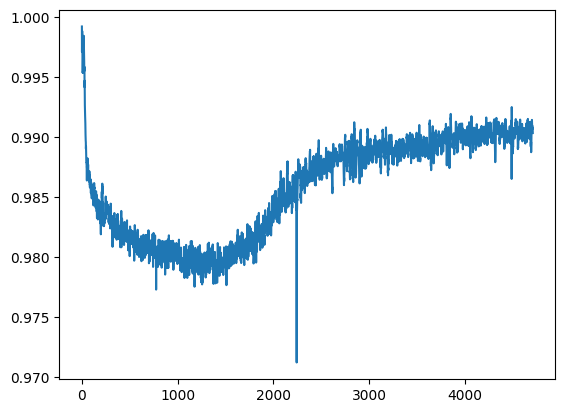

In [33]:
plt.plot(statistic_var)